In [66]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers


In [89]:
#load from data folders
# Paths to the dataset folders
train_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/train'
val_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/val'
test_dir = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/test'

# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# ImageDataGenerator for validation and test (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 4014 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [68]:
def count_files(directory):
    try:
        files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        return len(files)
    except FileNotFoundError:
        print("Directory not found.")
        return None

In [69]:
directory = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/train/fire'
print("fire images:", count_files(directory))
directory = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/train/non_fire'
print("Non- fire images:", count_files(directory))

KeyboardInterrupt: 

In [ ]:
# Step 1: Load the pre-trained ResNet50 model, exclude the top (fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Step 2: Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Step 3: Add custom classification layers on top of the frozen base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(512, activation='relu')(x)   # Another fully connected layer
output = Dense(1, activation='sigmoid')(x)  # Binary output for fire vs. no-fire

# Step 4: Create the model
model = Model(inputs=base_model.input, outputs=output)

# Step 5: Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Display model summary to verify the architecture
model.summary()


# Step 7: Train the model
# Assuming you have train_generator and validation_generator ready from ImageDataGenerator
history = model.fit(
    train_generator,
    steps_per_epoch=32,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20  # Adjust epochs as needed
)


In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)

plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc:.2f}')



In [ ]:
test_dir = '/kaggle/input/fire-detection-from-cctv/data/img_data/test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator2 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['default','fire']
)


In [90]:

# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3), kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model (assuming X_train, y_train, X_val, and y_val are pre-processed datasets)
history = model.fit(
    train_generator,
    steps_per_epoch=32,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20  # Adjust epochs as needed
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6333 - loss: 1.0057 - val_accuracy: 0.8083 - val_loss: 0.7708
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 880ms/step - accuracy: 0.8245 - loss: 0.7492 - val_accuracy: 1.0000 - val_loss: 0.3915
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 995ms/step - accuracy: 0.8083 - loss: 0.7099 - val_accuracy: 0.8708 - val_loss: 0.5828
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 793ms/step - accuracy: 0.8291 - loss: 0.6055 - val_accuracy: 0.8333 - val_loss: 0.5368
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.8365 - loss: 0.6256 - val_accuracy: 0.8708 - val_loss: 0.5289
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 880ms/step - accuracy: 0.8557 - loss: 0.5422 - val_accuracy: 0.8333 - val_loss: 0.5628
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 972ms/step - accuracy: 0.8615 - loss: 0.5381 - val_accuracy: 0.8729 - val_loss: 0.4880
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 792ms/step - accuracy: 0.8376 - loss: 0.5271 - val_accuracy: 

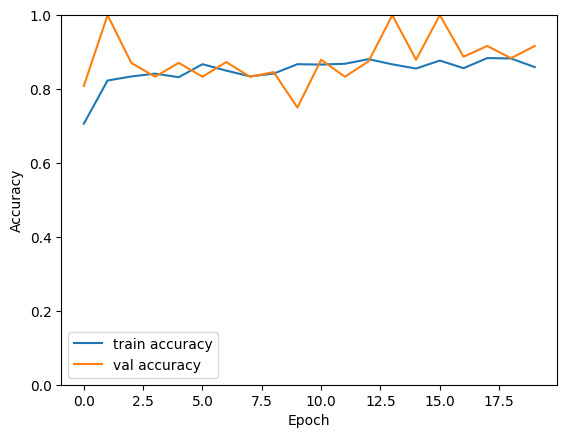

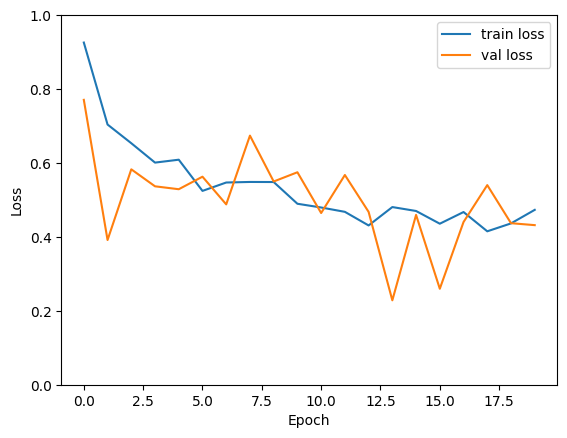

In [91]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0, 1)

plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 1)
plt.show()


**With Regularization and image transformation learning rate=0.0001**
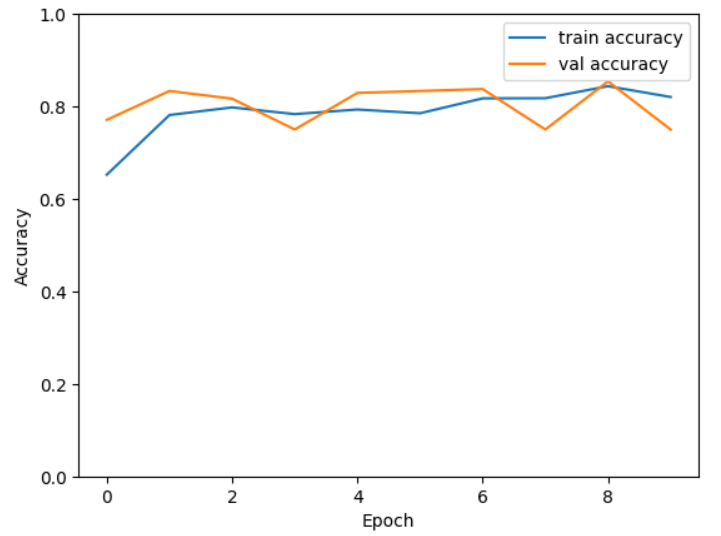
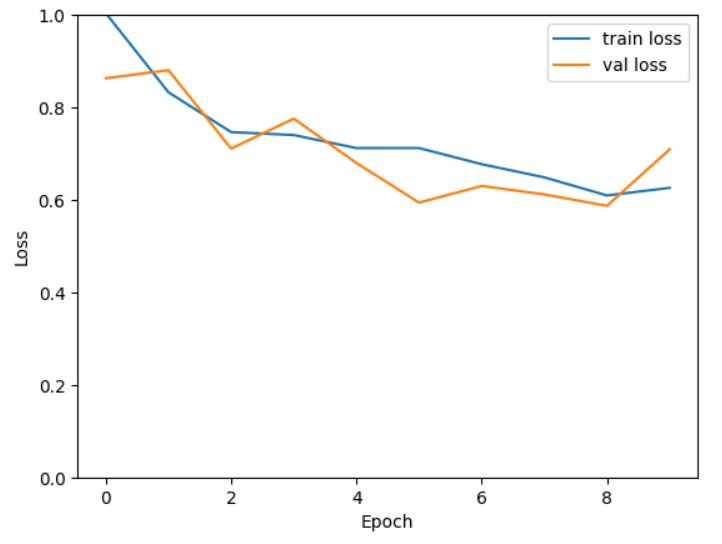

**With Regularization, Learning rate=0.01**
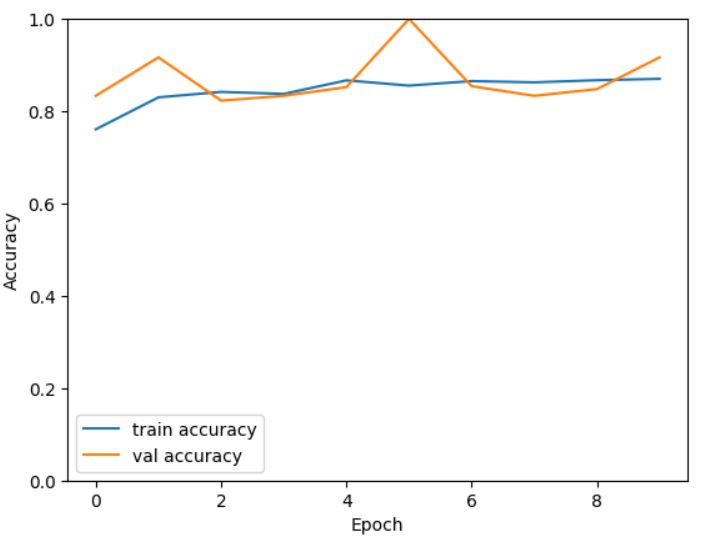
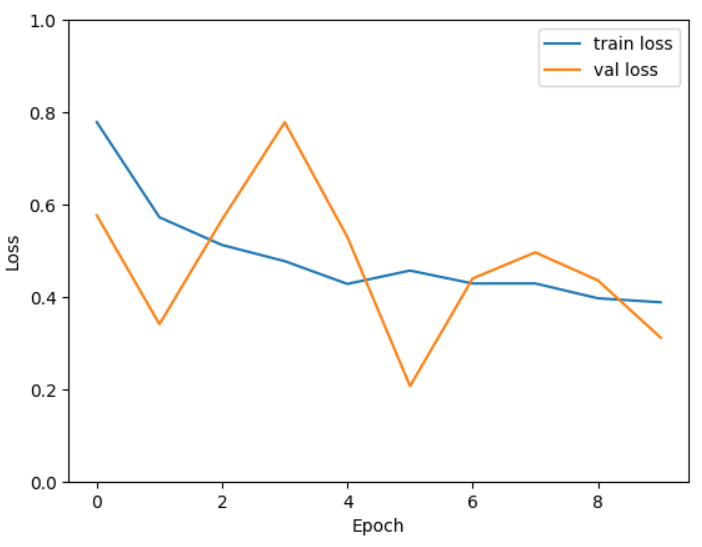

**Without Regularization**
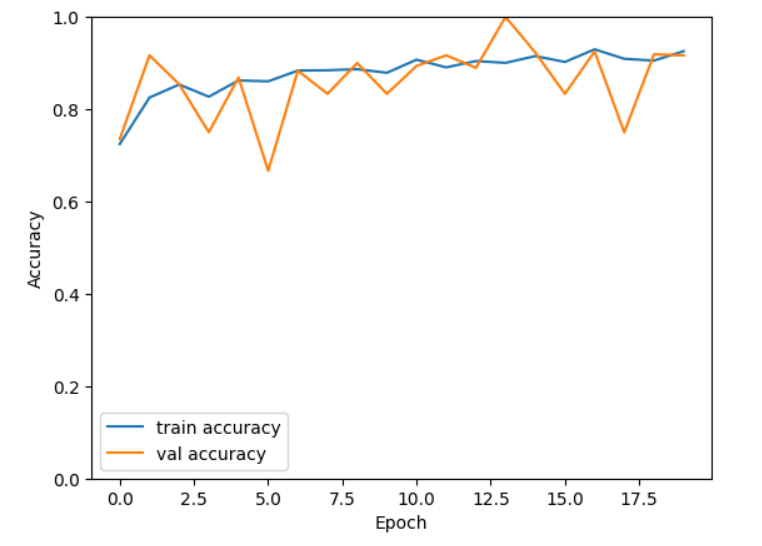
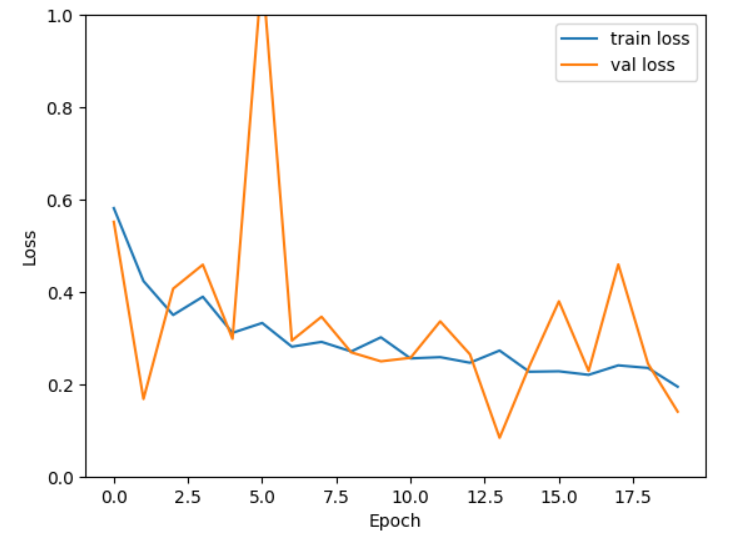

In [93]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test accuracy: {test_acc:.2f}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - accuracy: 0.8004 - loss: 0.5970
Test accuracy: 0.88


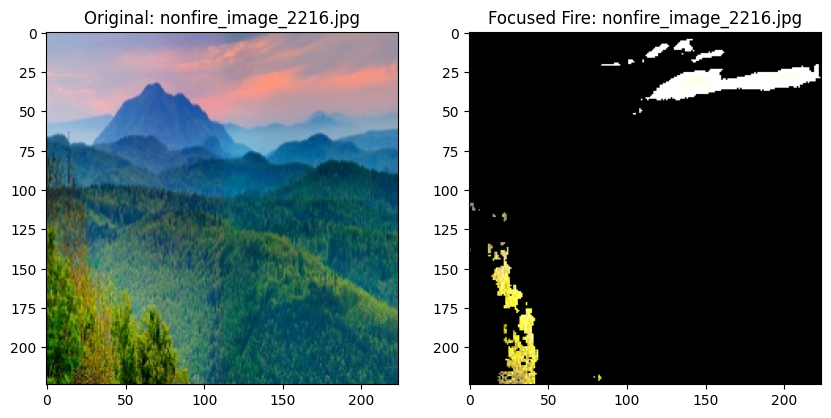

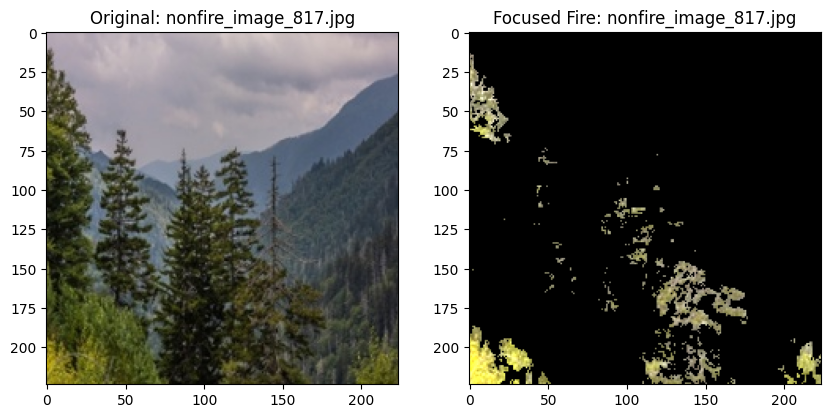

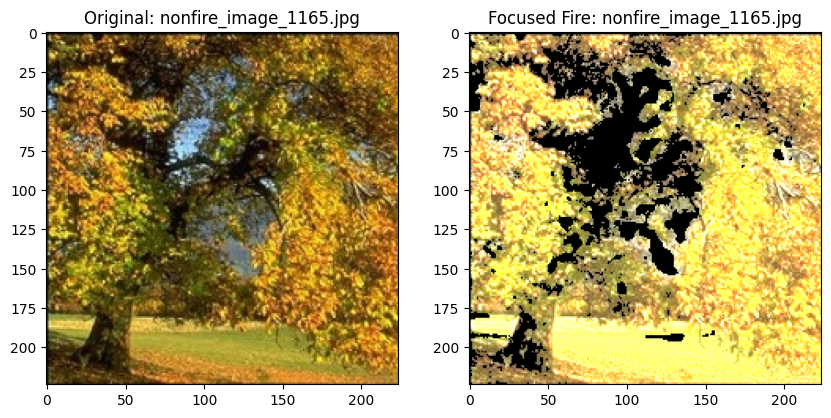

In [83]:
import cv2

# Path to the folder containing images
folder_path = '/kaggle/input/firedataset-jpg-224/FireDataset-V6-JPG-Reshaped224/val/non_fire'
save_path = '/kaggle/working/validate_transformed/non_fire'

# Create a list to hold all image paths
images = []

# Traverse through all directories and subdirectories
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.jpg'):
            # Add the full path of the image to the list
            images.append(os.path.join(root, file))

# Define fire color range (red, orange, yellow)
lower_fire = np.array([0, 50, 50])
upper_fire = np.array([30, 255, 255])


# Process each image in the folder
for i, image_path in enumerate(images):
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Create a mask for fire-colored pixels
    fire_mask = cv2.inRange(hsv, lower_fire, upper_fire)
    
    # Apply the mask to highlight fire regions
    fire_highlighted = cv2.bitwise_and(image, image, mask=fire_mask)
   
    # Increase the brightness and contrast in the fire-highlighted image
    alpha = 1.5  # Contrast control
    beta = 50    # Brightness control
    brightened_fire = cv2.convertScaleAbs(fire_highlighted, alpha=alpha, beta=beta)
    
    # Convert the mask to binary (0 or 1) to isolate fire regions
    _, binary_mask = cv2.threshold(fire_mask, 127, 255, cv2.THRESH_BINARY)
    
    # Apply the binary mask to focus on fire areas
    focused_fire = cv2.bitwise_and(brightened_fire, brightened_fire, mask=binary_mask)
    
    # Save the final transformed image
    base_filename = os.path.basename(image_path)
    final_path = os.path.join(save_path, f'final_{base_filename}')
    os.makedirs(save_path, exist_ok=True)
    cv2.imwrite(final_path, focused_fire)
    
    # Display the image
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    focused_fire_rgb = cv2.cvtColor(focused_fire, cv2.COLOR_BGR2RGB)

    if i % 100 == 0:
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image_rgb)
        plt.title(f'Original: {base_filename}')
        
        plt.subplot(1, 2, 2)
        plt.imshow(focused_fire_rgb)
        plt.title(f'Focused Fire: {base_filename}')
        
        plt.show()
    
    

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Path to the folder containing images
folder_path = 'path_to_images_folder'

# Get list of all images in the folder
images = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

# Define fire color range (red, orange, yellow)
lower_fire = np.array([0, 50, 50])
upper_fire = np.array([30, 255, 255])

# Process each image in the folder
for i, image_file in enumerate(images):
    image_path = os.path.join(folder_path, image_file)
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Create a mask for fire-colored pixels
    fire_mask = cv2.inRange(hsv, lower_fire, upper_fire)
    
    # Apply the mask to highlight fire regions
    fire_highlighted = cv2.bitwise_and(image, image, mask=fire_mask)
    
    # Save the transformed image (optional)
    highlighted_path = os.path.join(folder_path, f'highlighted_{image_file}')
    cv2.imwrite(highlighted_path, fire_highlighted)
    
    # Display the original and fire-highlighted images every nth image (e.g., every 5th image)
    if i % 5 == 0:
        # Convert BGR (OpenCV) to RGB (for Matplotlib)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        fire_highlighted_rgb = cv2.cvtColor(fire_highlighted, cv2.COLOR_BGR2RGB)

        # Display images using Matplotlib
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image_rgb)
        plt.title(f'Original: {image_file}')
        plt.subplot(1, 2, 2)
        plt.imshow(fire_highlighted_rgb)
        plt.title(f'Fire Highlighted: {image_file}')
        plt.show()


In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
import kerastuner as kt
import tensorflow as tf

def build_model(hp):
    model = Sequential()
    
    # Define possible kernel sizes as integers
    kernel_size_choices = [(3, 3), (5, 5)]
    
    # Conv2D layers with hyperparameter tuning
    for i in range(hp.Int('conv_layers', 1, 3)):
        filters = hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32)
        kernel_size_idx = hp.Choice(f'kernel_size_{i}', values=[0, 1])
        kernel_size = kernel_size_choices[kernel_size_idx]
        model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=(150, 150, 3) if i == 0 else None, kernel_regularizer=regularizers.l2(0.001)))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    # Dense layers with hyperparameter tuning
    for j in range(hp.Int('dense_layers', 1, 2)):
        units = hp.Int(f'units_{j}', min_value=64, max_value=128, step=64)
        model.add(Dense(units, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(hp.Float(f'dropout_{j}', min_value=0.3, max_value=0.6, step=0.1)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # Tuning the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [98]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='/kaggle/working',
    project_name='intro_to_kt'
)


In [99]:
tuner.search(
    train_generator,
    epochs=10,
    validation_data=val_generator
)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
1                 |1                 |conv_layers
128               |128               |filters_0
1                 |1                 |kernel_size_0
1                 |1                 |dense_layers
64                |64                |units_0
0.5               |0.5               |dropout_0
0.0020419         |0.0020419         |learning_rate

Epoch 1/10
  9/126 ━━━━━━━━━━━━━━━━━━━━ 3:55 2s/step - accuracy: 0.5334 - loss: 9.8693 

KeyboardInterrupt: 

In [ ]:
best_model = tuner.get_best_model()
best_hyperparameters = tuner.get_best_hyperparameters()[0]

print("Best Hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")
